# Pasos previos

* Lanzar los contendores de docker con zookeeper y kafka
* Ejecutar el script de python que lee los ficheros de log y los manda a kafka
* Verificar que se están recibiendo las lineas de log en kafka


### Lanzar los contenedores
```bash
cd ~/GitHub/pueacademyday19/kafka-zookeeper-docker
docker-compose up -d
```

### Ejecutar el script que manda los logs
```bash
cd ~/GitHub/pueacademyday19/log_generator
python tail_to_kafka.py -f logfile -t new_logs -s 1
```

# Spark Session

In [1]:
from IPython.display import clear_output
import time
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
spark = SparkSession \
    .builder \
    .appName("Fali2ban distributed") \
    .getOrCreate()
spark.conf.set( "spark.sql.shuffle.partitions" , 5 ) 

spark


# Definición de variales

In [2]:
topic="new_logs"
topic_ban_ip="ban_ip"
kakfa_borkers="localhost:9092"

# Kafka consumer

Store Kafka new_logs topic from localhost:9092 in df dataframe

In [140]:
df = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", kakfa_borkers) \
  .option("subscribe", topic) \
  .option("maxOffsetsPerTrigger", 100) \
  .option("startingOffsets", "earliest") \
  .load()
print(df.schema)

StructType(List(StructField(key,BinaryType,true),StructField(value,BinaryType,true),StructField(topic,StringType,true),StructField(partition,IntegerType,true),StructField(offset,LongType,true),StructField(timestamp,TimestampType,true),StructField(timestampType,IntegerType,true)))


# Stream query 0 RAW
Actualización cada 10s y append a tabla temporal df

In [4]:
q0 = df.writeStream.queryName("df") \
    .trigger(processingTime='10 seconds') \
    .format("memory").start() #Create temp table

Read the table using spark SQL

In [6]:
sql="select * from df "
print(spark.sql(sql).show(2))

+----+--------------------+--------+---------+------+--------------------+-------------+
| key|               value|   topic|partition|offset|           timestamp|timestampType|
+----+--------------------+--------+---------+------+--------------------+-------------+
|null|[41 70 72 20 32 3...|new_logs|        0|     0|2019-05-16 14:00:...|            0|
|null|[41 70 72 20 32 3...|new_logs|        0|     1|2019-05-16 14:00:...|            0|
+----+--------------------+--------+---------+------+--------------------+-------------+
only showing top 2 rows

None


In [7]:
sql="select timestamp, topic, cast(value as string) from df order by timestamp desc"
display(spark.sql(sql).limit(4).toPandas())

,timestamp,topic,value
0,2019-05-16 14:01:29.143,new_logs,Apr 28 04:18:41 s4 sshd[353598]: input_useraut...
1,2019-05-16 14:01:29.040,new_logs,Apr 28 04:18:41 s4 sshd[353598]: Invalid user ...
2,2019-05-16 14:01:28.936,new_logs,Apr 28 04:18:04 s4 sudo: pam_unix(sudo:session...
3,2019-05-16 14:01:28.831,new_logs,Apr 28 04:18:04 s4 sudo: pam_unix(sudo:session...


# ETL
Tranform lines to various columns

In [152]:
##UDF to parse date
def parse_date(word):
    from datetime import datetime
    try:
        date=datetime.strptime('2019 '+word, '%Y %b  %d %H:%M:%S')
        date.strftime('%a %H:%M:%S')
        return date.strftime('%Y-%m-%d %H:%M:%S')
    except ValueError:
        return ""
udf_parse_date=udf(parse_date)

##UDF to parse text
def parse_entry(word):
    word.split(":")[3:]
    return ':'.join(word.split(":")[3:])
udf_parse_entry=udf(parse_entry)     


#Define log table
#Columns definition
date_col=to_timestamp(udf_parse_date(col("value").cast('string').substr(1,15))).alias('timestamp')

temp_col=split(regexp_replace(col("value").cast('string'),' +',' '),' ')
server=temp_col[3].alias('server')
service=temp_col[4].alias('service')
log_entry=udf_parse_entry(col("value").cast('string')).alias('log_entry')

#New DF with structure
log_to_table=df.select(date_col,server,service,log_entry) \
   .dropDuplicates(['timestamp','server','service','log_entry'])
print(log_to_table.schema)

                    

StructType(List(StructField(timestamp,TimestampType,true),StructField(server,StringType,true),StructField(service,StringType,true),StructField(log_entry,StringType,true)))


# Stream query 1 Logs Table
Actualización cada 10s y append a tabla temporal log_to_table

In [143]:
q1 = log_to_table.writeStream.queryName("log_to_table") \
    .trigger(processingTime='10 seconds') \
    .format("memory").start() #Create temp table

In [207]:
import json
print("q1.isActive:", q1.isActive)
print("q1.lastProgress:", json.dumps(q1.lastProgress,indent=4, sort_keys=True))

q1.isActive: True
q1.lastProgress: {
    "batchId": 30,
    "durationMs": {
        "addBatch": 605,
        "getBatch": 0,
        "getEndOffset": 0,
        "queryPlanning": 13,
        "setOffsetRange": 5,
        "triggerExecution": 693,
        "walCommit": 41
    },
    "id": "29c49fe1-914e-4478-94b2-fd1d52e76653",
    "inputRowsPerSecond": 100.0100010001,
    "name": "log_to_table",
    "numInputRows": 1000,
    "processedRowsPerSecond": 1443.001443001443,
    "runId": "9c437494-40bd-4900-a6ab-399debabe9e1",
    "sink": {
        "description": "MemorySink"
    },
    "sources": [
        {
            "description": "KafkaV2[Subscribe[new_logs]]",
            "endOffset": {
                "new_logs": {
                    "0": 31000
                }
            },
            "inputRowsPerSecond": 100.0100010001,
            "numInputRows": 1000,
            "processedRowsPerSecond": 1443.001443001443,
            "startOffset": {
                "new_logs": {
               

In [222]:
from IPython.display import clear_output
import time



sql="select * from log_to_table order by timestamp desc"
print(spark.sql(sql).show(10))


sql="select count(*) c, server from log_to_table group by server"
print(spark.sql(sql).show(10))



+-------------------+------+-------------+--------------------+
|          timestamp|server|      service|           log_entry|
+-------------------+------+-------------+--------------------+
|2019-05-01 08:04:25|    s5|sshd[317257]:| Disconnected fro...|
|2019-05-01 08:04:25|    s5|sshd[317257]:| Invalid user ace...|
|2019-05-01 08:04:25|    s5|sshd[317257]:| Received disconn...|
|2019-05-01 08:04:25|    s5|sshd[317257]:| input_userauth_r...|
|2019-05-01 08:03:38|    s5|        sudo:| pam_unix(sudo:se...|
|2019-05-01 08:03:38|    s5|        sudo:| pam_unix(sudo:se...|
|2019-05-01 08:03:38|    s5|        sudo:|  icinga : TTY=un...|
|2019-05-01 08:03:26|    s5|sshd[317118]:| Received disconn...|
|2019-05-01 08:03:26|    s5|sshd[317118]:| Invalid user dee...|
|2019-05-01 08:03:26|    s5|sshd[317118]:| Disconnected fro...|
+-------------------+------+-------------+--------------------+
only showing top 10 rows

None
+-----+------+
|    c|server|
+-----+------+
|13480|    s4|
|24684|    s5

# Stream query 2 SSH Access Violations
Actualización cada 10s y append a tabla temporal

In [162]:
#Locate user
user=split(col('log_entry')," ")[3].alias('user')
#Locate IP
ip=split(col('log_entry')," ")[5].alias('ip')

ssh_access_violation=log_to_table \
    .where("log_entry like '%Invalid%'") \
    .where("service like '%sshd%'") \
    .select(col('timestamp'),col('server'),user,ip)
print(ssh_access_violation.schema)

StructType(List(StructField(timestamp,TimestampType,true),StructField(server,StringType,true),StructField(user,StringType,true),StructField(ip,StringType,true)))


In [165]:
q2 = ssh_access_violation.writeStream.queryName("ssh_access_violation") \
    .trigger(processingTime='10 seconds') \
    .format("memory").start() #Create temp table

In [166]:
import json
print("q2.isActive:", q1.isActive)
print("q2.lastProgress:", json.dumps(q1.lastProgress,indent=4, sort_keys=True))

q2.isActive: True
q2.lastProgress: {
    "batchId": 11,
    "durationMs": {
        "addBatch": 510,
        "getBatch": 0,
        "getEndOffset": 0,
        "queryPlanning": 13,
        "setOffsetRange": 2,
        "triggerExecution": 584,
        "walCommit": 33
    },
    "id": "29c49fe1-914e-4478-94b2-fd1d52e76653",
    "inputRowsPerSecond": 100.0,
    "name": "log_to_table",
    "numInputRows": 1000,
    "processedRowsPerSecond": 1712.328767123288,
    "runId": "9c437494-40bd-4900-a6ab-399debabe9e1",
    "sink": {
        "description": "MemorySink"
    },
    "sources": [
        {
            "description": "KafkaV2[Subscribe[new_logs]]",
            "endOffset": {
                "new_logs": {
                    "0": 12000
                }
            },
            "inputRowsPerSecond": 100.0,
            "numInputRows": 1000,
            "processedRowsPerSecond": 1712.328767123288,
            "startOffset": {
                "new_logs": {
                    "0": 11000
  

In [187]:
sql="select * from ssh_access_violation order by timestamp desc"
print(spark.sql(sql).show(10))

+-------------------+------+-----------+---------------+
|          timestamp|server|       user|             ip|
+-------------------+------+-----------+---------------+
|2019-04-29 18:18:30|    s4|redisserver|  111.53.76.186|
|2019-04-29 18:18:26|    s4|      halts|  111.53.76.186|
|2019-04-29 18:18:18|    s4|     admins|  111.53.76.186|
|2019-04-29 18:14:15|    s4|   customer|   112.216.6.43|
|2019-04-29 17:55:34|    s4|      user3|176.199.255.112|
|2019-04-29 17:52:32|    s4|    hamburg|   61.160.99.75|
|2019-04-29 17:41:07|    s4|       luna| 138.68.146.186|
|2019-04-29 17:26:25|    s4|         ts|  115.47.160.22|
|2019-04-29 17:24:23|    s4|         to|   51.38.113.45|
|2019-04-29 17:19:02|    s4|       test|    196.35.3.50|
+-------------------+------+-----------+---------------+
only showing top 10 rows

None


# Stream query 3 Windowing IPs to ban
Actualización cada 10s y append a tabla temporal

In [168]:
ips_to_ban_ips=ssh_access_violation \
    .groupBy(window(col('timestamp'),"5 minutes"),"ip") \
    .count() \
    .select("window.start","window.end","ip","count")

In [169]:
q3 = ips_to_ban_ips.writeStream.queryName("ips_to_ban") \
    .trigger(processingTime='10 seconds') \
    .outputMode("update").format("memory").start() #Create temp table

In [170]:
import json
print("q3.isActive:", q1.isActive)
print("q3.lastProgress:", json.dumps(q1.lastProgress,indent=4, sort_keys=True))

q3.isActive: True
q3.lastProgress: {
    "batchId": 13,
    "durationMs": {
        "addBatch": 436,
        "getBatch": 0,
        "getEndOffset": 0,
        "queryPlanning": 9,
        "setOffsetRange": 2,
        "triggerExecution": 522,
        "walCommit": 33
    },
    "id": "29c49fe1-914e-4478-94b2-fd1d52e76653",
    "inputRowsPerSecond": 99.99000099990002,
    "name": "log_to_table",
    "numInputRows": 1000,
    "processedRowsPerSecond": 1915.7088122605364,
    "runId": "9c437494-40bd-4900-a6ab-399debabe9e1",
    "sink": {
        "description": "MemorySink"
    },
    "sources": [
        {
            "description": "KafkaV2[Subscribe[new_logs]]",
            "endOffset": {
                "new_logs": {
                    "0": 14000
                }
            },
            "inputRowsPerSecond": 99.99000099990002,
            "numInputRows": 1000,
            "processedRowsPerSecond": 1915.7088122605364,
            "startOffset": {
                "new_logs": {
        

In [188]:
sql="select count(*) from ips_to_ban"
print(spark.sql(sql).show(1))

+--------+
|count(1)|
+--------+
|     356|
+--------+

None


In [189]:
sql="select * from ips_to_ban order by count desc"
print(spark.sql(sql).show(10))

+-------------------+-------------------+--------------+-----+
|              start|                end|            ip|count|
+-------------------+-------------------+--------------+-----+
|2019-04-28 09:35:00|2019-04-28 09:40:00| 200.68.26.218|   72|
|2019-04-28 09:35:00|2019-04-28 09:40:00| 200.68.26.218|   43|
|2019-04-28 05:25:00|2019-04-28 05:30:00|165.22.136.100|   21|
|2019-04-28 17:30:00|2019-04-28 17:35:00|  40.73.106.49|   13|
|2019-04-28 17:00:00|2019-04-28 17:05:00|  40.73.106.49|   13|
|2019-04-28 16:45:00|2019-04-28 16:50:00|  40.73.106.49|   13|
|2019-04-28 17:15:00|2019-04-28 17:20:00|  40.73.106.49|   13|
|2019-04-28 17:45:00|2019-04-28 17:50:00|  40.73.106.49|   13|
|2019-04-28 17:20:00|2019-04-28 17:25:00|  40.73.106.49|   12|
|2019-04-28 16:35:00|2019-04-28 16:40:00|  40.73.106.49|   12|
+-------------------+-------------------+--------------+-----+
only showing top 10 rows

None


# Stream query 3 Windowing IPs to ban to kafka topic


## Para leer la salida
```bash
kafka-console-consumer --topic ban_ip --bootstrap-server localhost:9092 --from-beginning
```

In [191]:
q4 = ips_to_ban_ips.where("count > 2") \
    .select(to_json(struct(col("end"),col("ip"),col("count"))).alias("value")) \
    .writeStream \
    .queryName("ips_to_ban_kafka") \
    .trigger(processingTime='10 seconds') \
    .format("kafka") \
    .outputMode("update")\
    .option("checkpointLocation", "test2") \
    .option("kafka.bootstrap.servers", kakfa_borkers) \
    .option("topic", topic_ban_ip) \
    .start()

In [192]:
import json
print("q4.isActive:", q1.isActive)
print("q4.lastProgress:", json.dumps(q1.lastProgress,indent=4, sort_keys=True))

q4.isActive: True
q4.lastProgress: {
    "batchId": 23,
    "durationMs": {
        "addBatch": 766,
        "getBatch": 0,
        "getEndOffset": 0,
        "queryPlanning": 11,
        "setOffsetRange": 3,
        "triggerExecution": 858,
        "walCommit": 37
    },
    "id": "29c49fe1-914e-4478-94b2-fd1d52e76653",
    "inputRowsPerSecond": 99.99000099990002,
    "name": "log_to_table",
    "numInputRows": 1000,
    "processedRowsPerSecond": 1165.5011655011656,
    "runId": "9c437494-40bd-4900-a6ab-399debabe9e1",
    "sink": {
        "description": "MemorySink"
    },
    "sources": [
        {
            "description": "KafkaV2[Subscribe[new_logs]]",
            "endOffset": {
                "new_logs": {
                    "0": 24000
                }
            },
            "inputRowsPerSecond": 99.99000099990002,
            "numInputRows": 1000,
            "processedRowsPerSecond": 1165.5011655011656,
            "startOffset": {
                "new_logs": {
       

# Interactive SQL

In [193]:
spark.sql("show tables").show()

+--------+--------------------+-----------+
|database|           tableName|isTemporary|
+--------+--------------------+-----------+
|        |                  df|       true|
|        |          ips_to_ban|       true|
|        |        log_to_table|       true|
|        |ssh_access_violation|       true|
+--------+--------------------+-----------+



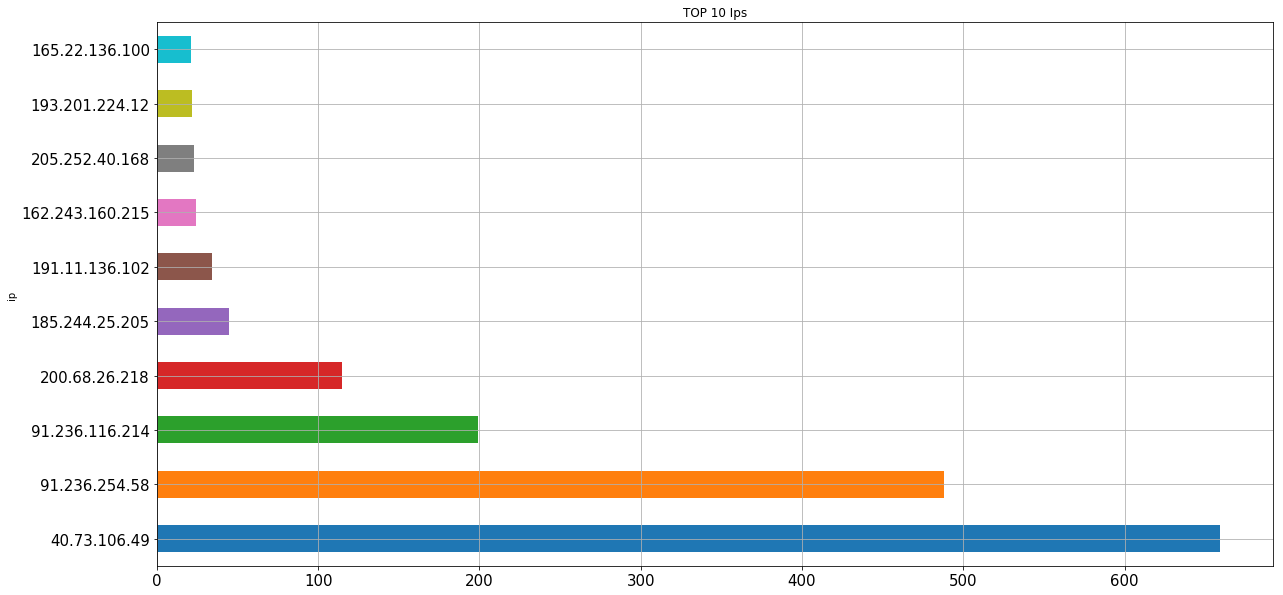

In [212]:
sql="select sum(count) as attacks, ip from ips_to_ban group by ip order by attacks desc limit 10"
p= spark.sql(sql).toPandas()
display(p.plot(x='ip',y='attacks',kind='barh', title="TOP 10 Ips", figsize=(20, 10), grid=True, fontsize=15, legend = False))

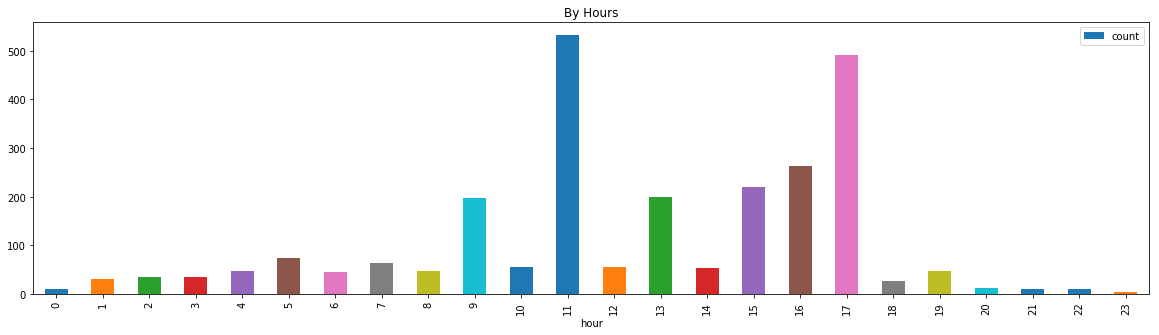

In [214]:
sql="select sum(count) as count , hour(start) as hour from ips_to_ban group by hour(start) order by hour"
p= spark.sql(sql).toPandas()
display(p.plot(x='hour',y='count',kind='bar', title="By Hours", figsize=(20, 5)))

In [141]:
q0.stop()
q1.stop()
q2.stop()
q3.stop()
q4.stop()